In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import operator
import pickle

In [3]:
help(pickle)

Help on module pickle:

NAME
    pickle - Create portable serialized representations of Python objects.

DESCRIPTION
    See module copyreg for a mechanism for registering custom picklers.
    See module pickletools source for extensive comments.
    
    Classes:
    
        Pickler
        Unpickler
    
    Functions:
    
        dump(object, file)
        dumps(object) -> string
        load(file) -> object
        loads(string) -> object
    
    Misc variables:
    
        __version__
        format_version
        compatible_formats

CLASSES
    builtins.Exception(builtins.BaseException)
        _pickle.PickleError
            _pickle.PicklingError
            _pickle.UnpicklingError
    builtins.object
        _pickle.Pickler
        _pickle.Unpickler
    
    class PickleError(builtins.Exception)
     |  Common base class for all non-exit exceptions.
     |  
     |  Method resolution order:
     |      PickleError
     |      builtins.Exception
     |      builtins.BaseExc

In [4]:
# cumput entropy of each features of the given dataset
from math import log
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {} # 这里一定有新的写法
    for featVect in dataSet: # 统计分类的频数
        currentLabel = featVect[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries # 每一类的概率
        shannonEnt -= prob*log(prob,2) # 香农熵，-log(prob,2) 为信息量，乘以对应类别的概率即为熵
    return shannonEnt

In [5]:
def createDataSet():
    dataSet = [[1,1,'yes'],
        [1,1,'yes'],
        [1,0,'no'],
        [0,1,'no'],
        [0,1,'no']]
    labels = ['no surfacing','flippers']
    return dataSet,labels
myData,labels = createDataSet()
calcShannonEnt(myData)

0.9709505944546686

In [6]:
# myData[0][-1]='maybe' # 分类的类别增加，熵增大
# print(myData)
# calcShannonEnt(myData)

In [7]:
def splitDataSet(dataSet,axis,value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
#             print(featVec[:axis])
#             reducedFeatVec = featVec[:axis]
#             print(featVec[axis+1:])
#             reducedFeatVec.extend(featVec[axis+1:])
            reducedFeatVec = featVec[:axis]+featVec[axis+1:] 
            # 排除被选择的特征，是为了方便计算子集的熵，该熵不能包含用于选择的特征
            # 被选择出来的特征取值要与value相同，体现挑选过程，方便计算（该特征相同取值）子集的熵
            retDataSet.append(reducedFeatVec)
    return retDataSet

In [8]:
splitDataSet(myData,1,1)

[[1, 'yes'], [1, 'yes'], [0, 'no'], [0, 'no']]

In [9]:
# 计算最优划分特征，对于给定数据集，仅考虑计算一层特征的拆分信息增益
def chooseBestFeatureToSplit(dataSet):
    baseEntropy = calcShannonEnt(dataSet) # 计算原始香农熵
    numFeatures = len(dataSet[0])-1 
    bestInfoGain = 0.0 # 最大信息增益（也即香农熵减少度，数据有序增加度）
    bestFeature = -1 # 最优划分特征的索引
    for i in range(numFeatures): #遍历每个用于划分的特征
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)
        newEntropy = 0.0
        for value in uniqueVals: # 根据每个特征遍历每一个取值，计算该划分方法的新信息熵
            subDataSet = splitDataSet(dataSet,i,value)
            prob = len(subDataSet)/len(dataSet)
            newEntropy += prob*calcShannonEnt(subDataSet) # 注意概率的引入
        infoGain = baseEntropy - newEntropy # 信息增益
        if infoGain > bestInfoGain:  # 挑出信息增益最大的即为最优划分特征
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature

In [10]:
chooseBestFeatureToSplit(myData)

0

In [11]:
# 终止条件：
# 用光所有特征
# 子集为相同类型
# 但存在用光所有特征但子集类型不一致的情况：投票，多数表决
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(),key=operator.itemgetter(1),reverse=True)
    return sortedClassCount[0][0]

In [12]:
def createTree(dataSet,labels):
    classList = [example[-1] for example in dataSet] # 分类结果列表
    if classList.count(classList[0]) == len(classList): # 子集为同一类，直接返回类型 # 这里同时也处理了子集元素只有一个的情况，防止继续分解子集
        return classList[0]
    if len(dataSet[0]) == 1: # 特征用完，但子集不是同一类，需要投票
        return majorityCnt(classList)
    bestFeature = chooseBestFeatureToSplit(dataSet) # 获取划分依据的最优特征
    bestFeatureLabel = labels[bestFeature] # 算法本省不强制，但是为了直观理解数据含义
    myTree = {bestFeatureLabel:{}} # 构造树，嵌套
    featValues = [example[bestFeature] for example in dataSet] # 该特征下所有取值子集
    uniqueValues = set(featValues)
    subLabels = labels[:bestFeature]+labels[bestFeature+1:] # 必须删除已用label，否则label顺序出现混乱
    for value in uniqueValues:
        myTree[bestFeatureLabel][value] = createTree(splitDataSet(dataSet,bestFeature,value),subLabels) # 对于划分出的子集，继续创建树
    return myTree

In [13]:
myTree = createTree(myData,labels)
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [14]:
def classify(inputTree,featLabels,testVect):
    firstStr = list(inputTree.keys())[0] # 每个树的入口都是一个label
    secondDict = inputTree[firstStr] # 该label的值为一个字典,是一个内层字典
    featIndex = featLabels.index(firstStr) # 将label转化为特征标签，目的是为了获取索引，以便从testVect取出特征的值
    for key in secondDict.keys():
        if testVect[featIndex] == key: # 对于分支的判断
            if type(secondDict[key]).__name__ == 'dict': # 这里说明还有子树，可以递归调用了
                classLabel = classify(secondDict[key],featLabels,testVect)
            else:
                classLabel = secondDict[key]
    return classLabel

In [15]:
classify(myTree,labels,[1,0])

'no'

In [16]:
classify(myTree,labels,[1,1])

'yes'

# 图形化展示

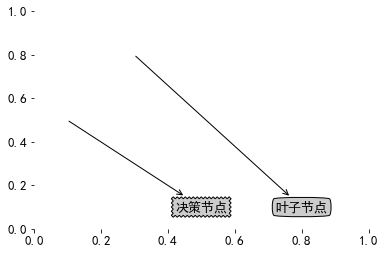

In [17]:
decisionNode = dict(boxstyle='sawtooth',fc='0.8')
leafNode = dict(boxstyle='round4',fc='0.8')
arrow_args = dict(arrowstyle='<-')
def plotNode1(nodeTxt,centerPt,parentPt,nodeType):
    createPlot1.ax1.annotate(nodeTxt,xy=parentPt,xycoords='axes fraction',xytext=centerPt,textcoords='axes fraction',va='center',ha='center',bbox=nodeType,arrowprops=arrow_args)
    
def createPlot1():
    plt.rc('font', family='SimHei', size=13) # 用于指定显示中文的字体，否则出现方块
    fig = plt.figure(1,facecolor='white')
    fig.clf()
    createPlot1.ax1 = plt.subplot(111,frameon=False)
    plotNode1('决策节点',(0.5,0.1),(0.1,0.5),decisionNode)
    plotNode1('叶子节点',(0.8,0.1),(0.3,0.8),leafNode)
    plt.show()
createPlot1()

In [18]:
# 确定横轴长度：获取叶子节点数
def getNumLeafs(myTree):
    numLeafs = 0
#     firstStr = list(myTree.keys())[0]
#     secondDict = myTree[firstStr]
    secondDict = list(myTree.values())[0]
    for key in secondDict.keys():
        if type(secondDict[key] ).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1 # 树分支遇到非字典就加1
    return numLeafs

# 确定纵轴高度：获取树层数
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            # 遇到子字典，也即遇到子树，层数总是要增加的
            thisDepth = 1+ getTreeDepth(secondDict[key])
        else:
            thisDepth = 1 # 树分支遇到非字典层数就为1
        #保留每个分支的最大深度
        if maxDepth < thisDepth:maxDepth = thisDepth
    return maxDepth

In [19]:
def retrieveTree(i):
    listOfTree = [
        {'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
        {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head':{0:'no',1:'yes'}}, 1: 'no'}}}}
    ]
    return listOfTree[i]

In [20]:
getNumLeafs(retrieveTree(1))

4

In [21]:
getTreeDepth(retrieveTree(1))

3

In [22]:
decisionNode = dict(boxstyle='sawtooth',fc='0.8')
leafNode = dict(boxstyle='round4',fc='0.8')
arrow_args = dict(arrowstyle='<-')
plt.rc('font', family='SimHei', size=13) # 用于指定显示中文的字体，否则出现方块
def plotNode(nodeTxt,centerPt,parentPt,nodeType):
    createPlot.ax1.annotate(nodeTxt,xy=parentPt,xycoords='axes fraction',xytext=centerPt,textcoords='axes fraction',va='center',ha='center',bbox=nodeType,arrowprops=arrow_args)
    
# 绘制分支上的标签
def plotMidText(cntrPt,parentPt,textString):
    xMid = (parentPt[0] - cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid,yMid,textString)

# 绘制树
# 重要参考 https://www.cnblogs.com/fantasy01/p/4595902.html
def plotTree(myTree,parentPt,nodeText):
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    print("当前树的叶子数 %d"%numLeafs)
    print("当前树的深度 %d"%depth)
    firstStr = list(myTree.keys())[0]
    print("当前树的label %s"%firstStr)
    secondDict = myTree[firstStr]
    print("上一绘制的起始位置 %f"%plotTree.xOff)
    cntrPt = (plotTree.xOff + (1.0 + numLeafs)/2.0/plotTree.totalW, plotTree.yOff)  
#     cntrPt = (plotTree.xOff + 1.0/2/plotTree.totalW + numLeafs/2/plotTree.totalW, plotTree.yOff)
    # numLeafs个数决定了这一层树所有叶子节点所占宽度，当前选择节点位于该宽度的中间，numLeafs/2.0/plotTree
    # numLeafs)/2.0/plotTree 代表了整个子树的宽度的一半，不论这一子树的大小，numLeafs)/plotTree 总是能将这一子树放得下，
    # 1.0/2.0/plotTree.totalW 代表了横向上向右移动半个单位
    print("父节点位置 %s"%str(parentPt))
    print("子节点位置 %s"%str(cntrPt))
    plotMidText(cntrPt,parentPt,nodeText)
    plotNode(firstStr,cntrPt,parentPt,decisionNode) # 绘制树判断节点
#     plotNode('no surfacing',(0.5, 1.0),(0.5, 1.0),decisionNode)
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD  # 纵向上高度下降一个子树高度
    # 深度优先策略
    print("绘制完选择框更新纵坐标 %f"%plotTree.yOff)
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key],cntrPt,str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW # 为了方便这里更新叶子节点横坐标，所以将起始绘图位置设置左偏半个位置
            print("更新绘制横坐标，准备绘制叶子节点%f"%plotTree.xOff)
            plotNode(secondDict[key],(plotTree.xOff,plotTree.yOff),cntrPt,leafNode)
            plotMidText((plotTree.xOff,plotTree.yOff),cntrPt,str(key))
    plotTree.yOff = plotTree.yOff +1.0/plotTree.totalD
    # 深度优先策略，在绘制完该深度所有子节点的时候需要返回之前的位置
    print("当前树绘制完成， 更新纵坐标 %f"%plotTree.yOff)
    


# 创建绘图区域，递归调用plotTree()
def createPlot(inTree):
    fig = plt.figure(1,facecolor='white')
    fig.clf()
#     axprops = dict(xticks=[],yticks=[]) # 用于去掉坐标轴编号
#     createPlot.ax1 = plt.subplot(111,frameon=False,**axprops) # 参数解包语法
    createPlot.ax1 = plt.subplot(111,frameon=False)
    plotTree.totalW = getNumLeafs(inTree)
    plotTree.totalD = getTreeDepth(inTree)
    plotTree.xOff = -0.5/plotTree.totalW # 起始位置左移半个单位宽度，以后leaf间距+1即可
    plotTree.yOff = 1.0
    plotTree(inTree,(0.5,1.0),'')
    plt.show()
    

首先由于整个画布根据叶子节点数和深度进行平均切分，并且x轴的总长度为1,即如同下图：

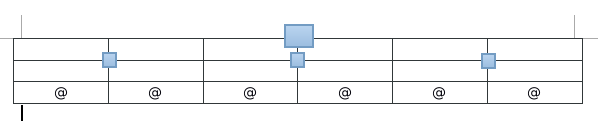

1、其中方形为非叶子节点的位置，@是叶子节点的位置，因此每份即上图的一个表格的长度应该为1/plotTree.totalW,但是叶子节点的位置应该为@所在位置，则在开始的时候plotTree.xOff的赋值为-0.5/plotTree.totalW,即意为开始x位置为第一个表格左边的半个表格距离位置，这样作的好处为：在以后确定@位置时候可以直接加整数倍的1/plotTree.totalW,

2、对于plotTree函数中的红色部分即如下：

cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
plotTree.xOff即为最近绘制的一个叶子节点的x坐标，在确定当前节点位置时每次只需确定当前节点有几个叶子节点，因此其叶子节点所占的总距离就确定了即为float(numLeafs)/plotTree.totalW*1(因为总长度为1)，因此当前节点的位置即为其所有叶子节点所占距离的中间即一半为float(numLeafs)/2.0/plotTree.totalW*1，这样保证了节点位于其叶子节点的中间，但是由于开始plotTree.xOff赋值并非从0开始，而是左移了半个表格，因此还需加上半个表格距离即为1/2/plotTree.totalW*1,则加起来便为(1.0 + float(numLeafs))/2.0/plotTree.totalW*1，因此偏移量确定，则x位置变为plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW

3、对于plotTree函数参数赋值为(0.5, 1.0)

因为开始的根节点并不用划线，因此父节点和当前节点的位置需要重合，利用2中的确定当前节点的位置便为(0.5, 1.0)

总结：利用这样的逐渐增加x的坐标，以及逐渐降低y的坐标能能够很好的将树的叶子节点数和深度考虑进去，因此图的逻辑比例就很好的确定了，这样不用去关心输出图形的大小，一旦图形发生变化，函数会重新绘制，但是假如利用像素为单位来绘制图形，这样缩放图形就比较有难度了

当前树的叶子数 4
当前树的深度 3
当前树的label no surfacing
上一绘制的起始位置 -0.125000
父节点位置 (0.5, 1.0)
子节点位置 (0.5, 1.0)
绘制完选择框更新纵坐标 0.666667
更新绘制横坐标，准备绘制叶子节点0.125000
当前树的叶子数 3
当前树的深度 2
当前树的label flippers
上一绘制的起始位置 0.125000
父节点位置 (0.5, 1.0)
子节点位置 (0.625, 0.6666666666666667)
绘制完选择框更新纵坐标 0.333333
当前树的叶子数 2
当前树的深度 1
当前树的label head
上一绘制的起始位置 0.125000
父节点位置 (0.625, 0.6666666666666667)
子节点位置 (0.5, 0.3333333333333334)
绘制完选择框更新纵坐标 0.000000
更新绘制横坐标，准备绘制叶子节点0.375000
更新绘制横坐标，准备绘制叶子节点0.625000
当前树绘制完成， 更新纵坐标 0.333333
更新绘制横坐标，准备绘制叶子节点0.875000
当前树绘制完成， 更新纵坐标 0.666667
当前树绘制完成， 更新纵坐标 1.000000


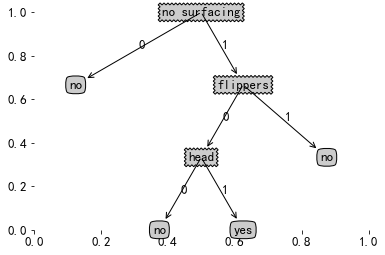

In [23]:
myTree = retrieveTree(1)
myTree['no surfacing'][3] = 'maybe'
createPlot( retrieveTree(1))

In [24]:
myTree

{'no surfacing': {0: 'no',
  1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}},
  3: 'maybe'}}

# 序列化，使用时加载，学习时间长，预测速度快

In [25]:
# 序列化对象
def storeTree(inputTree,filename):
    with open(filename,'wb') as fw:
        pickle.dump(inputTree,fw)
def grabTree(filename):
    with open(filename,'rb') as fr:
        return pickle.load(fr)

In [26]:
storeTree(myTree,'DecisionTree.txt')

In [27]:
loadTree = grabTree('DecisionTree.txt')
loadTree

{'no surfacing': {0: 'no',
  1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}},
  3: 'maybe'}}

当前树的叶子数 9
当前树的深度 4
当前树的label tearRate
上一绘制的起始位置 -0.055556
父节点位置 (0.5, 1.0)
子节点位置 (0.5, 1.0)
绘制完选择框更新纵坐标 0.750000
更新绘制横坐标，准备绘制叶子节点0.055556
当前树的叶子数 8
当前树的深度 3
当前树的label astigmatic
上一绘制的起始位置 0.055556
父节点位置 (0.5, 1.0)
子节点位置 (0.5555555555555556, 0.75)
绘制完选择框更新纵坐标 0.500000
当前树的叶子数 4
当前树的深度 2
当前树的label age
上一绘制的起始位置 0.055556
父节点位置 (0.5555555555555556, 0.75)
子节点位置 (0.33333333333333337, 0.5)
绘制完选择框更新纵坐标 0.250000
更新绘制横坐标，准备绘制叶子节点0.166667
更新绘制横坐标，准备绘制叶子节点0.277778
当前树的叶子数 2
当前树的深度 1
当前树的label prescript
上一绘制的起始位置 0.277778
父节点位置 (0.33333333333333337, 0.5)
子节点位置 (0.4444444444444444, 0.25)
绘制完选择框更新纵坐标 0.000000
更新绘制横坐标，准备绘制叶子节点0.388889
更新绘制横坐标，准备绘制叶子节点0.500000
当前树绘制完成， 更新纵坐标 0.250000
当前树绘制完成， 更新纵坐标 0.500000
当前树的叶子数 4
当前树的深度 2
当前树的label prescript
上一绘制的起始位置 0.500000
父节点位置 (0.5555555555555556, 0.75)
子节点位置 (0.7777777777777778, 0.5)
绘制完选择框更新纵坐标 0.250000
当前树的叶子数 3
当前树的深度 1
当前树的label age
上一绘制的起始位置 0.500000
父节点位置 (0.7777777777777778, 0.5)
子节点位置 (0.7222222222222222, 0.25)
绘制完选择框更新纵坐标 0.000000
更新绘制横坐标，准备绘制叶子节点0.

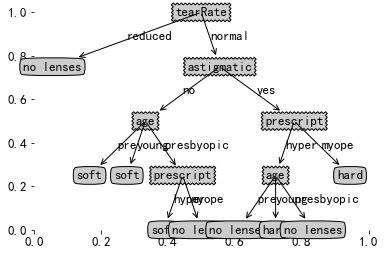

In [28]:
with open('./lenses.txt','r') as fr:
    lenses = [line.strip().split('\t')for line in fr.readlines()]
lensesLabels = ['age','prescript','astigmatic','tearRate']
lensesTree = createTree(lenses,lensesLabels)
createPlot(lensesTree)